In [1]:
import numpy as np

In [2]:
# - make numpy print numbers to 4dp only
np.set_printoptions(precision=4, suppress=True)

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
# - set gray colormap and nearest neighbor interpolation by default
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

In [4]:
import nipy
import nipy.core.api as nica
from nipy.algorithms.registration import HistogramRegistration, resample

In [5]:
img = nipy.load_image('ds114_sub009_t2r1.nii')
mean_data = img.get_data()[..., 4:].mean(axis=-1)
# Drop the time dimension from the coordinate map
coordmap_3d = nica.drop_io_dim(img.coordmap, 't')
mean_img = nica.Image(mean_data, coordmap_3d)

In [6]:
source = nipy.load_image('ds114_sub009_highres_brain.nii')
target = mean_img

In [7]:
source.coordmap

AffineTransform(
   function_domain=CoordinateSystem(coord_names=('i', 'j', 'k'), name='voxels', coord_dtype=float64),
   function_range=CoordinateSystem(coord_names=('scanner-x=L->R', 'scanner-y=P->A', 'scanner-z=I->S'), name='scanner', coord_dtype=float64),
   affine=array([[  -1.    ,    0.    ,    0.    ,  122.7012],
                 [   0.    ,    1.3002,   -0.    ,  -86.6199],
                 [  -0.    ,    0.    ,    1.    , -173.3327],
                 [   0.    ,    0.    ,    0.    ,    1.    ]])
)

In [8]:
# Resample structural to functional without transform
source_before = resample(source, np.eye(4), reference=target)

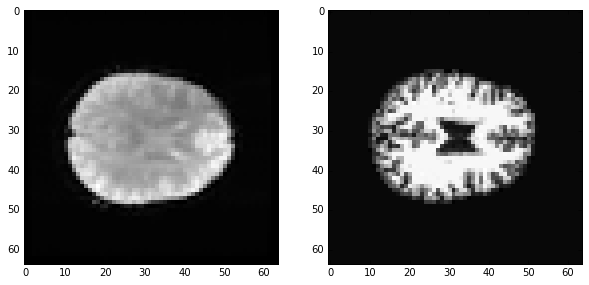

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(target.get_data()[:, :, 15])
axes[1].imshow(source_before.get_data()[:, :, 15])

Disturb the registration to give the algorithm something to do

In [10]:
source.affine[0, -1] += 10
source_before = resample(source, np.eye(4), reference=target)

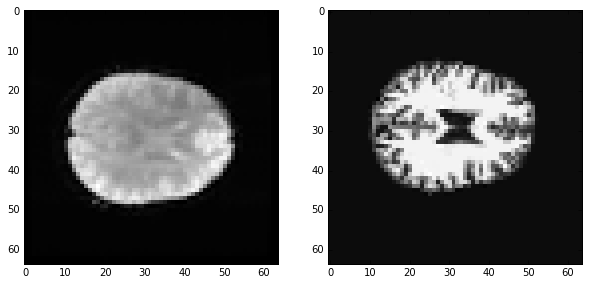

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(target.get_data()[:, :, 15])
axes[1].imshow(source_before.get_data()[:, :, 15])

In [12]:
registration = HistogramRegistration(source, target, similarity='nmi', interp='rand')
transform = registration.optimize('rigid', optimizer='powell')

Initial guess...
translation : [ 0.  0.  0.]
rotation    : [ 0.  0.  0.]

Optimizing using fmin_powell
translation : [-7.9602  2.618   5.2361]
rotation    : [ 0.01    0.01    0.0216]

nmi = 0.258296532583

translation : [-11.8202   2.618    5.618 ]
rotation    : [ 0.0038 -0.0062  0.0154]

nmi = 0.267002082381

translation : [-12.4383   2.       6.618 ]
rotation    : [-0.0124 -0.0124 -0.0007]

nmi = 0.267601898138

Optimization terminated successfully.
         Current function value: -0.267599
         Iterations: 3
         Function evaluations: 147


In [13]:
transform.as_affine()

array([[  0.9999,   0.0008,  -0.0124, -12.4383],
       [ -0.0007,   0.9999,   0.0124,   2.    ],
       [  0.0124,  -0.0124,   0.9998,   6.618 ],
       [  0.    ,   0.    ,   0.    ,   1.    ]])

In [14]:
# HistogramRegistration?

In [15]:
source_after = resample(source, transform.inv(), reference=target)

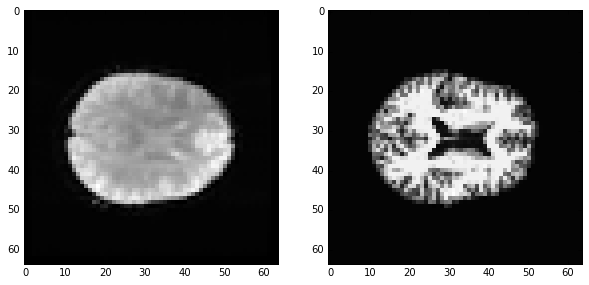

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(target.get_data()[:, :, 15])
axes[1].imshow(source_after.get_data()[:, :, 15])